In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
## for data
import pandas as pd

import re
import nltk## for language detection


In [3]:
df = pd.read_csv('justice.csv')
df.dropna(inplace=True)
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [4]:
df1 = df.copy()

In [5]:
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area', 
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

In [6]:
df_cat = df1[['decision_type', 'disposition']]

In [7]:
df_target = df1['first_party_winner']

In [8]:
df_nlp = df1['facts']

In [9]:
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

In [10]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_target= label_encoder.fit_transform(df_target)

In [11]:
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


In [12]:
frames = [df_cat, df_target1]
df_concat = pd.concat(frames, axis=1, join='inner')
df_concat

,decision_type,disposition,first_party_winner
0,majority opinion,reversed/remanded,1
1,majority opinion,reversed/remanded,1
2,majority opinion,reversed/remanded,1
3,majority opinion,vacated/remanded,1
4,majority opinion,reversed,1
...,...,...,...
3093,majority opinion,reversed/remanded,1
3094,majority opinion,reversed/remanded,1
3095,majority opinion,affirmed,0
3096,majority opinion,vacated/remanded,1


In [13]:
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])

In [14]:
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


In [15]:
corpus = df_nlp1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

In [16]:
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [17]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [18]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [19]:
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [20]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


In [21]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [22]:
df_nlp2["first_party_winner"].value_counts()

first_party_winner
1    2067
0    1031
Name: count, dtype: int64

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

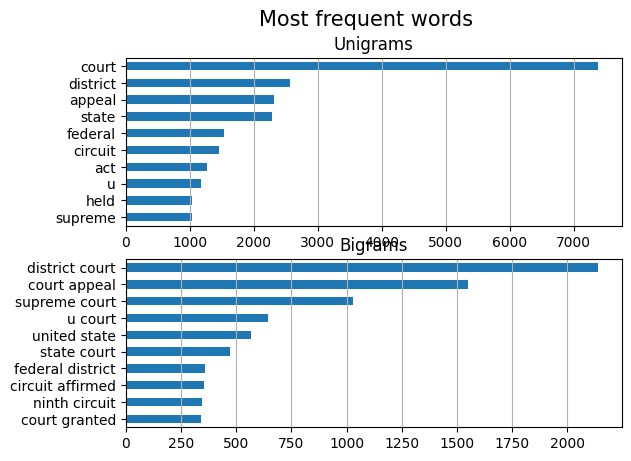

In [24]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

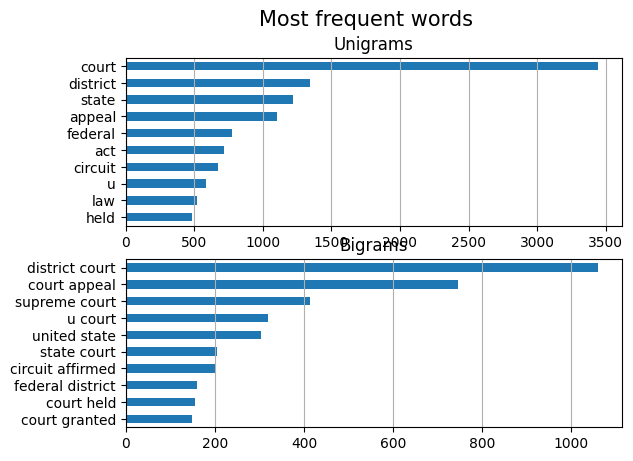

In [25]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [26]:
import wordcloud

In [27]:
!pip install wordcloud

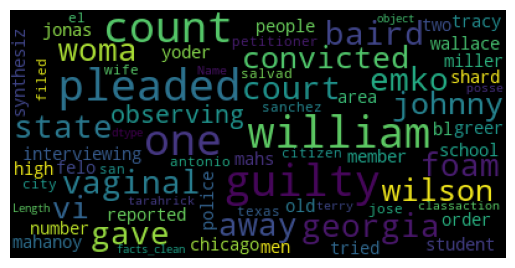

In [28]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [29]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

NameError: name 'gensim' is not defined

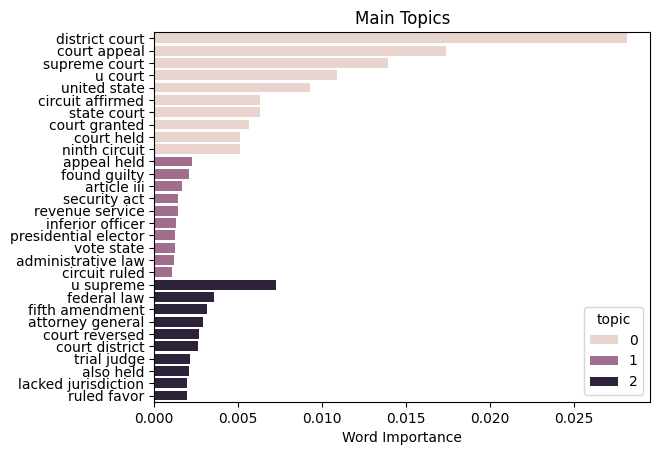

In [31]:
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_nlp2 is your DataFrame and it's already defined

y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"] == y]["facts_clean"]

# Pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, len(lst_words), 2)]
    lst_corpus.append(lst_grams)

# Map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)  # Create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus]  # Prepare corpus for LDA

# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Output topics
lst_dics = []
for i in range(0, 3):  # Get top 3 topics
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic": i, "id": tupla[0], 
                         "word": id2word[tupla[0]], 
                         "weight": tupla[1]})

dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic', 'id', 'word', 'weight'])

# Plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()


In [30]:
!pip install gensim

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
vectorizer = CountVectorizer()

In [36]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [37]:
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.25)

In [39]:
pipe = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(solver='liblinear'))])

In [40]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(solver='liblinear'))])

In [41]:
pipe.score(X_test,y_test)

0.6012903225806452

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [43]:
pipe1= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])

In [44]:
pipe1.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

In [45]:
pipe1.score(X_train,y_train)

1.0

In [46]:
pipe1.score(X_test,y_test)

0.6735483870967742

In [53]:
pipe2= Pipeline(steps=[('cv',CountVectorizer()),('rf',KNeighborsClassifier(n_neighbors=3))])

In [55]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf', KNeighborsClassifier(n_neighbors=3))])

In [57]:
pipe2.score(X_train,y_train)

0.8570813603099441

In [58]:
pipe2.score(X_test,y_test)

0.6335483870967742

In [59]:
df_nl1=pd.concat([df_nlp2,df_cat],axis=1,join='inner')

In [60]:
df_nl1

,facts,facts_clean,first_party_winner,decision_type,disposition
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded


In [61]:
xfeatures1 = df_nl1[['facts_clean','decision_type','disposition']]
ylabel1 = df_nl1['first_party_winner']

In [62]:
df_cat1 = pd.get_dummies(df_cat['decision_type'])

In [63]:
df_cat2 = pd.get_dummies(df_cat['disposition'])

In [64]:
df_cat3=pd.concat([df_cat2,df_cat1],axis=1,join='inner')

In [65]:
df_cat3.columns

Index(['affirmed', 'none', 'reversed', 'reversed in-part',
       'reversed in-part/remanded', 'reversed/remanded', 'vacated',
       'vacated in-part/remanded', 'vacated/remanded',
       'dismissal - improvidently granted', 'dismissal - moot',
       'dismissal - other', 'equally divided', 'majority opinion',
       'opinion of the court', 'per curiam', 'plurality opinion'],
      dtype='object')

In [66]:
df_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')

In [67]:
vectorize=CountVectorizer()

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Assuming df_nl1 is your DataFrame and it's already defined
# Create an instance of CountVectorizer
vectorize = CountVectorizer()

# Fit and transform the 'facts_clean' column of your DataFrame
count_matrix = vectorize.fit_transform(df_nl1['facts_clean'])

# Convert the sparse matrix to an array
count_array = count_matrix.toarray()

# Create a DataFrame with the word counts
data_final = pd.DataFrame(data=count_array, columns=vectorize.get_feature_names_out())

# Display the resulting DataFrame
print(data_final)


      011119  0125  01657  019  02  036539  04  041352  041581  045323  ...  \
0          0     0      0    0   0       0   0       0       0       0  ...   
1          0     0      0    0   0       0   0       0       0       0  ...   
2          0     0      0    0   0       0   0       0       0       0  ...   
3          0     0      0    0   0       0   0       0       0       0  ...   
4          0     0      0    0   0       0   0       0       0       0  ...   
...      ...   ...    ...  ...  ..     ...  ..     ...     ...     ...  ...   
3093       0     0      0    0   0       0   0       0       0       0  ...   
3094       0     0      0    0   0       0   0       0       0       0  ...   
3095       0     0      0    0   0       0   0       0       0       0  ...   
3096       0     0      0    0   0       0   0       0       0       0  ...   
3097       0     0      0    0   0       0   0       0       0       0  ...   

      zoneofinterests  zoning  zt  zubik  zuni  zur

In [70]:
data_final = pd.concat([data_final,df_cat3],axis=1,join='inner')

In [71]:
data_final

,011119,0125,01657,019,02,036539,04,041352,041581,045323,...,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,True,False,False,False,False,True,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
3094,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
3095,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,0
3096,0,0,0,0,0,0,0,0,0,0,...,True,False,False,False,False,True,False,False,False,1


In [72]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']),
                                                    data_final['first_party_winner'], 
                                                    test_size=0.3,random_state=10)

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_final = scaler.fit_transform(data_final)

In [74]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda_data = lda.fit_transform(X_train)

In [75]:
lda_data_train = pd.DataFrame(data=lda_data)

In [76]:
lda_data_test = pd.DataFrame(data=lda.transform(X_test))

In [77]:
rand=RandomForestClassifier(max_depth= 8, max_features = 100, min_samples_leaf = 2, n_estimators = 200)

In [78]:
rand.fit(lda_data_train,y_train)

RandomForestClassifier(max_depth=8, max_features=100, min_samples_leaf=2,
                       n_estimators=200)

In [79]:
rand.score(lda_data_train,y_train)

0.6997232472324724

In [80]:
rand.score(lda_data_test,y_test)

0.6634408602150538

In [81]:
from sklearn.metrics import f1_score

In [82]:
y_pred1 = rand.predict(lda_data_test)
f1_score(y_test, y_pred1)

0.7955584585238407

In [83]:
rand.score(lda_data_test,y_test)

0.6634408602150538

In [ ]:
from sklearn.metrics import f1_score

In [84]:
y_pred1 = rand.predict(lda_data_test)
f1_score(y_test, y_pred1)

0.7955584585238407

In [85]:
model = XGBClassifier()
model.fit(lda_data_train, y_train)
y_pred = model.predict(lda_data_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1_score(y_test, y_pred1)

Accuracy: 66.13%


0.7955584585238407